## Introduction


This notebook goes beyond context() tools.


#### context(query, top_k=5)
- Searches the core knowledge pack’s vector database of text chunks.  
- Returns the top matching snippets with IDs, text, and relevance scores.  
- **Purpose:** retrieve authoritative guidance from curated docs.  

#### getImage(query)
- Searches an image-caption vector database for diagrams/photos relevant to the query.  
- Displays likley image with captions and file paths.  
- **Purpose:** give visual reinforcement (e.g., bandage diagrams, water purification images).  

#### knowledgeMeta()
- Reads pack metadata (from a manifest file).  
- Returns the current version and last-updated date of the knowledge pack.  
- **Purpose:** build trust by showing how recent and reliable the knowledge is.  


#### math tools: multiply, add, subtract, divide  
- **Purpose:** do math

###  Setting up paths and loading vector store

In [1]:
# === 0) Imports & manifest ===
from pathlib import Path
import yaml, json
from typing import Optional, List, Dict
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.tools import tool
from langchain.schema import Document

# If you want the prebuilt ReAct agent:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

# If you prefer to also expose tools directly on the LLM:
from langchain.chat_models import init_chat_model

# --- Set your pack root + manifest ---
ROOT = Path("/Users/ktejwani/Personal CS Projects/Summer 2025/Offline AI Kiosk/Offline-AI-Kiosk/first_aid_pack_demo_v2")
MANIFEST = ROOT / "manifest.yaml"

with open(MANIFEST, "r", encoding="utf-8") as f:
    manifest = yaml.safe_load(f)

# --- Resolve FAISS paths from manifest ---
faiss_dir_text = ROOT / manifest["precomputed_indices"]["text"]["faiss"]["dir"]
faiss_dir_image = ROOT / manifest["precomputed_indices"]["images"]["faiss"]["dir"]
# --- Create embeddings *matching the store* ---
embed_model_name = manifest["embedding_config"]["text"]["model"]     #same for text and image
emb = OllamaEmbeddings(model=embed_model_name)

# --- Load FAISS store + retriever ---
text_vs = FAISS.load_local(str(faiss_dir_text), emb, allow_dangerous_deserialization=True)
text_retriever = text_vs.as_retriever(search_kwargs={"k": 4})  # default k; tool will override if provided

image_vs = FAISS.load_local(str(faiss_dir_image), emb, allow_dangerous_deserialization=True)
# results = image_vs.similarity_search_with_score(query, k=4)






### Defining helper and context() Tool  

In [2]:
# === 1) Helpers ===
def format_chunk(doc: Document, max_chars: int = 400) -> Dict:
    """Return a dict with compact text + key metadata for prompting & audit."""
    txt = doc.page_content.strip()
    if len(txt) > max_chars:
        txt = txt[:max_chars].rstrip() + " …"
    m = doc.metadata
    return {
        "id": m.get("chunk_id"),
        "topic_id": m.get("topic_id"),
        "file_id": m.get("file_id"),
        "locale": m.get("locale"),
        "path": m.get("path"),
        "citations": [c.get("title", "") for c in m.get("citations", [])],
        "text": txt
    }

def format_context_block(chunks: List[Dict]) -> str:
    """Human/LLM-friendly context block the agent can drop into its reasoning."""
    lines = []
    lines.append("### Retrieved Context (use only what is relevant)")
    for i, c in enumerate(chunks, 1):
        cite_str = "; ".join([t for t in c["citations"] if t]) or "—"
        head = f"[{i}] {c['topic_id']} · {c['file_id']} · {c['locale']} · {c['path']}"
        lines.append(head)
        lines.append(c["text"])
        lines.append(f"Source(s): {cite_str}")
        lines.append("")  # blank line
    return "\n".join(lines).strip()


# === 2) The @tool: context() ===
@tool
def context(
    query: str,
    k: int = 4,
    topic_id: Optional[str] = None,
    locale: Optional[str] = None
) -> dict:
    """
    Retrieve up to k relevant knowledge-pack chunks for 'query' and return a formatted
    context block + structured per-chunk data for citations. You must use this tool for any prompt that is 
    important to wellbeing or safety of user. 

    Args:
        query: Natural language question or keywords.
        k: Top-k chunks to return (default 4).
        topic_id: Optional manifest topic filter (e.g., 'bleed-control').
        locale: Optional locale filter (e.g., 'hi_en' or 'en').

    Returns:
        {
          "query": str,
          "k": int,
          "filters": {"topic_id":..., "locale":...},
          "context_block": str,     # pasteable into prompts
          "chunks": [ {id, topic_id, file_id, path, locale, citations[], text}, ... ]
        }
    """
    # Build a metadata filter if provided
    _filter = {}
    # if topic_id:
    #     _filter["topic_id"] = topic_id
    # if locale:
    #     _filter["locale"] = locale

    # Run retrieval (override k)
    local_ret = text_vs.as_retriever(search_kwargs={"k": k})
    hits: List[Document] = local_ret.invoke(query) if not _filter else local_ret.invoke(query, filter=_filter)

    formatted = [format_chunk(d) for d in hits]
    ctx_block = format_context_block(formatted)
    return {
        "query": query,
        "k": k,
        "filters": _filter,
        "context_block": ctx_block,
        "chunks": formatted
    }


### Math Tools

In [3]:
@tool
def add(a: float, b: float) -> float:
    """Add two numbers.
    
    Args:
        a: First float
        b: Second float
    """
    return a + b

@tool
def subtract(a: float, b: float) -> float:
    """Subtract first number by second number.

    Args:
        a: First float
        b: Second float
    """
    return a - b

@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers.

    Args:
        a: First float
        b: Second float
    """
    return a * b

@tool
def divide(a : float, b: float) -> float:
    """Divide first number by second number.
    
    Args:
        a: First float
        b: Second float
    """
    if b == 0:
        return 0
    else:
        return a/b


### Defining knowledgeMeta() tool

In [10]:
from langchain.tools import tool
from pathlib import Path
import yaml
from typing import Optional

@tool
def knowledgeMeta(pack_dir: Optional[str] = None) -> dict:
    """
    Read a knowledge pack manifest and return metadata for trust and recency. 

    Args:
      pack_dir: Absolute or relative path to the pack folder (containing manifest.yaml).
                If omitted, uses the default ROOT pack path.

    Returns:
      {
        "name": str,
        "version": str,
        "date": str,
        "locales": [..],
        "topics_count": int,
        "manifest_path": str
      }
    """
    # default to your earlier ROOT if not provided
    base = Path(pack_dir) if pack_dir else ROOT
    manifest_path = base / "manifest.yaml"
    if not manifest_path.exists():
        return {"error": f"manifest.yaml not found at {manifest_path}"}

    with open(manifest_path, "r", encoding="utf-8") as f:
        m = yaml.safe_load(f)

    name = m.get("name", str(base.name))
    version = m.get("version", "unknown")
    date = m.get("date", "unknown")
    locales = m.get("locales", [])
    topics = m.get("index_of_topics", []) or []
    return {
        "name": name,
        "version": version,
        "date": date,
        "locales": locales,
        "topics_count": len(topics),
        "manifest_path": str(manifest_path)
    }


### getImage tool

In [ ]:
from langchain_core.tools import tool
from IPython.display import Image, display
from pathlib import Path
from typing import Dict, Any

HIGH_SCORE_THRESHOLD = 0.55  # tune as needed

@tool
def getImage(query: str) -> Dict[str, Any]:
    """
    Retrieve and display exactly one image for the user's query.
    Applies a high-confidence threshold; returns NO_IMAGE if nothing clears the bar.
    """
    q = (query or "").strip()
    pack_name    = manifest.get("name", "")
    pack_ver     = manifest.get("version", "")
    pack_date    = manifest.get("date", "")
    pack_locales = manifest.get("locales", [])

    if not q:
        return {
            "status": "NO_IMAGE",
            "name": pack_name,
            "version": pack_ver,
            "date": pack_date,
            "locales": pack_locales,
            "pack_name": pack_name,
            "image_path": "",
            "score": None,
            "citations": []
        }

    # Use similarity_search_with_score to get confidence scores
    foundImage = False
    minScore = 0.32
    finalDoc  = Document(page_content="")
    results = image_vs.similarity_search_with_score(query, k=4)
    finScore = 0
    from IPython.display import Image, display

    for i, (d, score) in enumerate(results, 1):
        
        if score >= minScore:
            finScore = score
            finalDoc = d
            foundImage = True
            break
    

    if not foundImage:
        print("NOT FOUND")
        return {
            "status": "NO_IMAGE",
            "name": pack_name,
            "version": pack_ver,
            "date": pack_date,
            "locales": pack_locales,
            "pack_name": pack_name,
            "image_path": "",
            "score": None,
            "citations": []
        }
    else:
        print("Found FOUND")
        img_path = ROOT / finalDoc.metadata['path']
        try:
            display(Image(filename=img_path))
        except Exception:
            pass
            
        return {
            "status": "OK",
            "name": pack_name,
            "version": pack_ver,
            "date": pack_date,
            "locales": pack_locales,
            "pack_name": pack_name,
            "image_path": finalDoc.metadata['Path'],
            "score": finScore,
            "citations": finalDoc.metadata.get("citations", [])
        }
        


### List of Available Tools

In [12]:
# Keep a Tools list for whichever orchestration you choose:
TOOLS = [context,add,multiply,subtract,divide,knowledgeMeta, getImage]

### Setting Up LLM

In [13]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    model="ollama:gpt-oss:20b",       
    temperature=0.2  # lower = more deterministic
)

llm_with_tools = llm.bind_tools(TOOLS) #llm_with_tools is a new wrapped llm
model = llm_with_tools

### Testing Tool Requests

In [14]:
from langchain_core.messages import HumanMessage
#message classes on lang chain inlcude human massage ,ai message, system message, and tool message
query = "call get image to show torniquet on leg"

messages = [HumanMessage(query)]

ai_msg = llm_with_tools.invoke(messages) #llm_with_tools looks at history(currently only 1 human message) and then builds prompt
print("AI MESSAEGE CALLS")
print(ai_msg)
print("JUST AI TOOL CALLS")
print(ai_msg.tool_calls) 
#Now we add the bots message to the chat history
messages.append(ai_msg)

AI MESSAEGE CALLS
content='' additional_kwargs={} response_metadata={'model': 'gpt-oss:20b', 'created_at': '2025-09-01T03:54:39.367001Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3783701875, 'load_duration': 98159000, 'prompt_eval_count': 628, 'prompt_eval_duration': 2305318292, 'eval_count': 48, 'eval_duration': 1379302625, 'model_name': 'gpt-oss:20b'} id='run--95a80b5b-e515-4212-ba2d-cd218f8b5879-0' tool_calls=[{'name': 'getImage', 'args': {'query': 'tourniquet on leg'}, 'id': 'f96fdfd9-df18-4808-8531-e7d52c750281', 'type': 'tool_call'}] usage_metadata={'input_tokens': 628, 'output_tokens': 48, 'total_tokens': 676}
JUST AI TOOL CALLS
[{'name': 'getImage', 'args': {'query': 'tourniquet on leg'}, 'id': 'f96fdfd9-df18-4808-8531-e7d52c750281', 'type': 'tool_call'}]


IMAGE FOUND FOR QUERY:tourniquet on leg

[1] (score=0.6101)
PATH: assets/bleeding/tourniquet.png
Asset id: img-tourniquet
Locale: hi_en
Citations: ['Improvised tourniquets: Obsolete or obligatory?']
Image caption:
Step-by-step improvised tourniquet using cloth and stick. Severe Bleeding. 


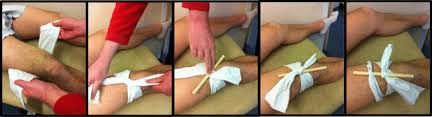

[HumanMessage(content='call get image to show torniquet on leg', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b', 'created_at': '2025-09-01T03:54:39.367001Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3783701875, 'load_duration': 98159000, 'prompt_eval_count': 628, 'prompt_eval_duration': 2305318292, 'eval_count': 48, 'eval_duration': 1379302625, 'model_name': 'gpt-oss:20b'}, id='run--95a80b5b-e515-4212-ba2d-cd218f8b5879-0', tool_calls=[{'name': 'getImage', 'args': {'query': 'tourniquet on leg'}, 'id': 'f96fdfd9-df18-4808-8531-e7d52c750281', 'type': 'tool_call'}], usage_metadata={'input_tokens': 628, 'output_tokens': 48, 'total_tokens': 676}),
 ToolMessage(content='{"status": "OK", "name": "Eastern Bihar – First Aid & Community Health | पूर्वी बिहार – प्राथमिक चिकित्सा", "version": "0.3.1", "date": "2025-08-23", "locales": ["hi", "en"], "pack_name": "Eastern Bihar – First Aid & Community He

In [15]:
for tool_call in ai_msg.tool_calls: #Actually running all the tool calls ai requested in last cell
    tools_dict = {"context": context, "knowledgeMeta":knowledgeMeta,"add":add,
            "subtract":subtract,"divide":divide,"multiply":multiply, "getImage":getImage}
    selected_tool = tools_dict[tool_call["name"]]
    tool_msg = selected_tool.invoke(tool_call)
    messages.append(tool_msg) #Add the tool message to chat history

messages


### Reason - Act Agent Sim

In [ ]:
from typing import (
    Annotated, #Extra metadata
    Sequence, #generic list container
    TypedDict, #Lets you define a dictionary type with fixed keys and types
) #a dictionary type has a specific format of what key and valye types can be 
from langchain_core.messages import BaseMessage #lang chain message format (Human,Systen,AI)
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]
#define a state dictionary, 1 key names messages
#messages is a list of langchain base messages
#wrapping it in Annotated tells it to not replace entire list but use add_messages to merge it in
#The accepected value  for this dictionary will be Sequence[BaseMessage]

### Defining nodes and edges in "Lang graph"

Lang graph:
- Imagine you're in a big construction truck and you have a map of stops
- Each stop pick up something/do a 
- Folow the street signs to get to all the stops
- Take a photo to save state during important jobs

The big truck carries chat histroy. The road signs are edges between nodes where nodes are the stops. The photos are state changes you can reload to(checkpoint in video game)

In [ ]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_dict = {"context": context, "knowledgeMeta":knowledgeMeta,"add":add,
            "subtract":subtract,"divide":divide,"multiply":multiply, "getImage":getImage}

tools_by_name = tools_dict


# Define our tool node
def tool_node(state: AgentState): #Agent State is the conversation history
    outputs = []
    for tool_call in state["messages"][-1].tool_calls: #Look at the last message in history(should be AIMessage)
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"]) #Actually call the tool
        outputs.append( #Add a json output to conco hsitory
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    temp_system_str = "For ANY health or safety query, you MUST call the `context` tool.  Do not answer from memory."
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!" + temp_system_str
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

### Defining new Graph

In [ ]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is 
    print(Exception)
    pass
# display(Image(graph.get_graph().draw_mermaid_png()))

### Print output stream function

In [ ]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        prev_msg = ""
        if len(s['messages']) > 1:
            prev_msg = s["messages"][-2]

        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
        # if prev_msg != "":
        #     if isinstance(prev_msg, tuple):
        #         print(prev_msg)
        #     else:
        #         prev_msg.pretty_print()


# inputs = {"messages": [("user", "What to do if bleed? When Knowledge updated? What 42*321 and 32/31?")]}
# print_stream(graph.stream(inputs, stream_mode="values"))

### Infinte Loop Chat Bot

After eahc exit please restart kernel and clear all outputs to ensure a fresh conversation.

In [ ]:
# === Simple REPL loop for Jupyter ===
def chat_loop():
    history = []
    print("Type a message. Commands: /reset, /exit\n")
    while True:
        user = input("You: ").strip()
        if not user:
            continue
        if user.lower() in {"/exit", "/quit"}:
            print("Bye!")
            break
        if user.lower() == "/reset":
            history = []
            print("(conversation cleared)")
            continue

        # Append user turn
        inputs = {"messages": history + [("user", user)]}

        # Use YOUR print_stream exactly as written
        print_stream(graph.stream(inputs, stream_mode="values"))

        # Capture updated history so context persists
        final_state = graph.invoke(inputs)
        history = final_state["messages"]

# Run this cell in your notebook to start chatting
chat_loop()


:)